# Above 8 000: Data at Altitude

## Basic setup

### Import necessary libraries  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Ignore casting warnings

In [20]:
pd.set_option('future.no_silent_downcasting', True)

### Load information from the datasets

In [2]:
members = pd.read_csv('data\\members.csv',   low_memory=False)          # ~89 k rows
peaks   = pd.read_csv('data\\peaks.csv',     low_memory=False)          # ~480 rows
exped   = pd.read_csv('data\\exped.csv',     low_memory=False)          # ~11 k rows
refer   = pd.read_csv('data\\refer.csv',     encoding='latin1')         # ~16 k rows
ddict   = pd.read_csv('data\\himalayan_data_dictionary.csv')            # data dictionary

## Data Analysis

### How many expeditions took place in each year?

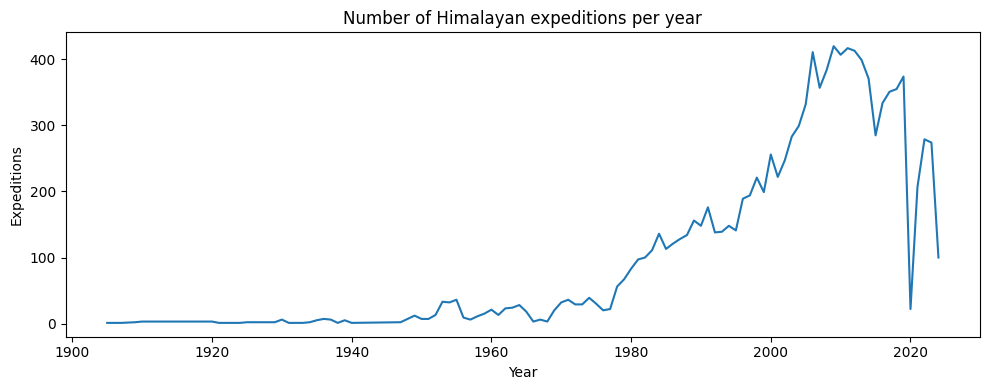

In [8]:
(exped["year"]
    .value_counts()
    .sort_index()
    .plot.line(
        figsize=(10,4),
        title="Number of Himalayan expeditions per year",
        xlabel="Year",
        ylabel="Expeditions"
    ))
plt.tight_layout()
plt.show()

### Number of expeditions with bottled oxygen use 

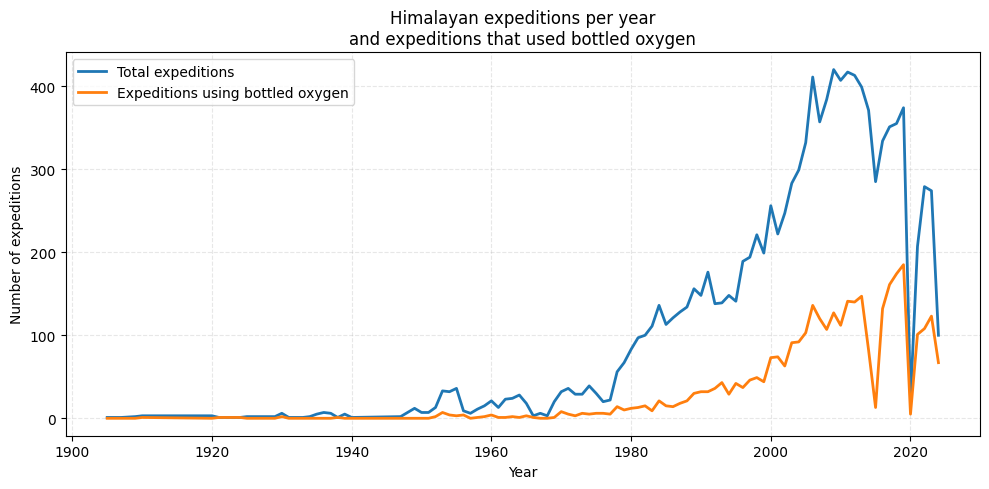

In [22]:
o2_flag = (members
           .groupby("expid")["mo2used"]
           .any()
           .rename("o2_used")
           .reset_index()
           .astype({"o2_used": "bool"})
)

exped_annot = (exped[["expid", "year"]]
              .merge(o2_flag, on="expid", how="left")
              .fillna({"o2_used": False})
)

total_per_year = exped_annot["year"].value_counts().sort_index()

o2_per_year = (exped_annot[exped_annot["o2_used"]]
               .groupby("year")
               .size()
               .reindex(total_per_year.index, fill_value=0))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(total_per_year.index, total_per_year.values,
        label="Total expeditions", linewidth=2)

ax.plot(o2_per_year.index, o2_per_year.values,
        label="Expeditions using bottled oxygen", linewidth=2)

ax.set_title("Himalayan expeditions per year\nand expeditions that used bottled oxygen")
ax.set_xlabel("Year")
ax.set_ylabel("Number of expeditions")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

### Oxygen use over time

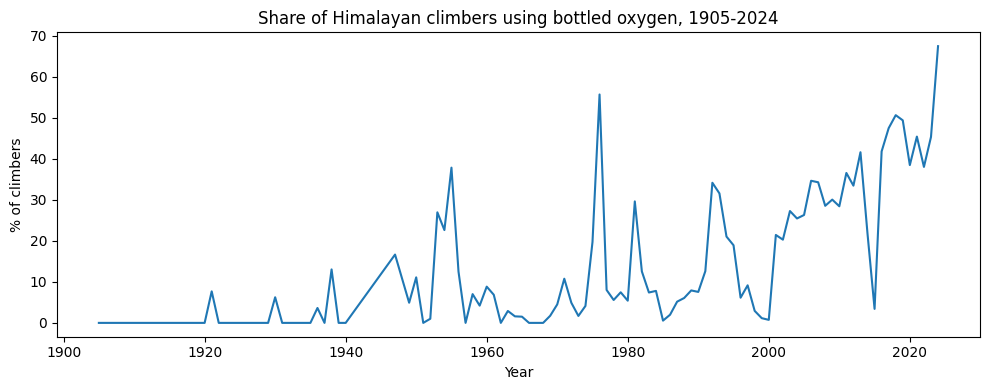

In [23]:
( members                                # DataFrame loaded from members.csv
    .dropna(subset=['myear'])            # just in case some rows lack a year
    .groupby('myear')['mo2used']         # every season’s climbers
    .mean()                              # True/False → share
    .mul(100)                            # turn into %
    .plot.line(
        figsize=(10,4),
        title='Share of Himalayan climbers using bottled oxygen, 1905-2024',
        ylabel='% of climbers',
        xlabel='Year'
    )
)

plt.tight_layout()
plt.show()

### Success vs fatality rate, rolling window

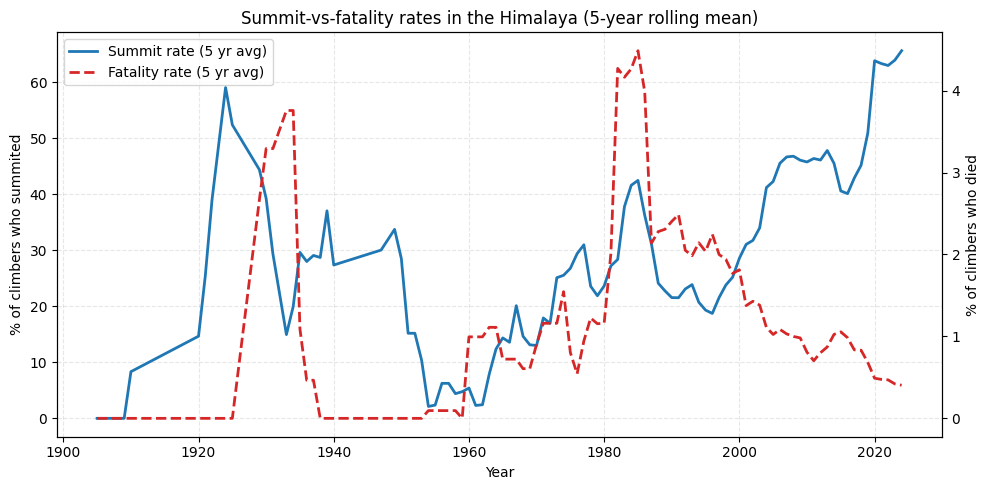

In [31]:
yr = (members
      .groupby("myear", as_index=True)
      .agg(
          summits  = ("msuccess",  "sum"),   # count of summiting climbers
          deaths   = ("death",    "sum"),     # count of deaths
          climbers = ("membid", "count")      # total people on record that year
      )
)

rate = (yr[["summits", "deaths"]]
          .div(yr["climbers"], axis=0)      # summit% and death% as fractions
          .rolling(5, min_periods=1)        # 5-year window, start gentle
          .mean()
          .mul(100)                         # turn 0-1 into %
        )

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(rate.index, rate["summits"],
         label="Summit rate (5 yr avg)",
         linewidth=2)

ax2 = ax1.twinx()   # secondary y-axis
ax2.plot(rate.index, rate["deaths"],
         label="Fatality rate (5 yr avg)",
         linewidth=2, linestyle="--", color="tab:red")

ax1.set_xlabel("Year")
ax1.set_ylabel("% of climbers who summited")
ax2.set_ylabel("% of climbers who died")
ax1.set_title("Summit-vs-fatality rates in the Himalaya (5-year rolling mean)")

lines  = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

ax1.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()